In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import issparse
import shap


/Users/yangyungchyi/Documents/Winter 2026/ML/Final Project/Airbnb-Renting-Optimizer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/yangyungchyi/Documents/Winter 2026/ML/Final Project/Chicago_Airbnb_Master_v2.csv')
df.head()


,listing_id,price,accommodates,bedrooms,bathrooms,room_type,property_type,review_scores_rating,occupancy_proxy,weekend_occupancy_proxy,summer_occupancy_proxy,winter_occupancy_proxy,total_review_count,recent_review_count,avg_review_length,estimated_annual_revenue,log_revenue
0,2384,119.0,1,1.0,1.0,Private room,Private room in condo,4.99,0.046575,0.048077,0.000000,0.000000,257.0,10.0,378.642023,2023.0,7.612831
1,7126,89.0,2,1.0,1.0,Entire home/apt,Entire rental unit,4.73,0.172603,0.182692,0.086957,0.077778,595.0,47.0,267.315966,5607.0,8.631949
2,10945,203.0,4,2.0,1.0,Entire home/apt,Entire rental unit,4.74,0.109589,0.115385,0.000000,0.000000,129.0,24.0,238.837209,8120.0,9.002209
3,12140,339.0,3,1.0,1.0,Private room,Room in boutique hotel,4.95,0.572603,0.605769,1.000000,0.000000,19.0,3.0,251.631579,70851.0,11.168348
4,28749,258.0,6,3.0,2.0,Entire home/apt,Entire loft,4.83,0.797260,0.807692,1.000000,0.766667,265.0,37.0,308.388679,75078.0,11.226296


## EDA

In [3]:
print(df.shape)
print(df.columns)
df.isna().mean().sort_values(ascending=False)


(7306, 17)
Index(['listing_id', 'price', 'accommodates', 'bedrooms', 'bathrooms',
       'room_type', 'property_type', 'review_scores_rating', 'occupancy_proxy',
       'weekend_occupancy_proxy', 'summer_occupancy_proxy',
       'winter_occupancy_proxy', 'total_review_count', 'recent_review_count',
       'avg_review_length', 'estimated_annual_revenue', 'log_revenue'],
      dtype='str')


review_scores_rating        0.173008
bedrooms                    0.000821
bathrooms                   0.000274
listing_id                  0.000000
summer_occupancy_proxy      0.000000
estimated_annual_revenue    0.000000
avg_review_length           0.000000
recent_review_count         0.000000
total_review_count          0.000000
winter_occupancy_proxy      0.000000
occupancy_proxy             0.000000
weekend_occupancy_proxy     0.000000
price                       0.000000
property_type               0.000000
room_type                   0.000000
accommodates                0.000000
log_revenue                 0.000000
dtype: float64

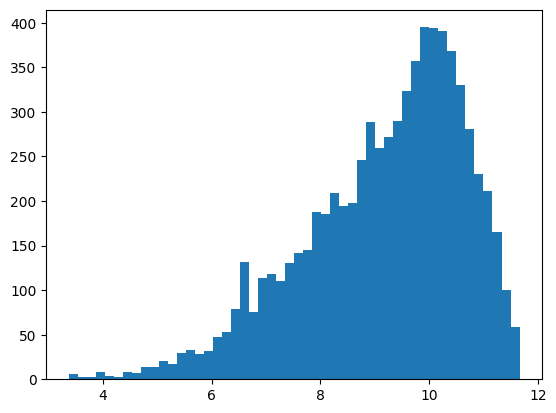

In [4]:
plt.hist(df["log_revenue"], bins=50)
plt.show()

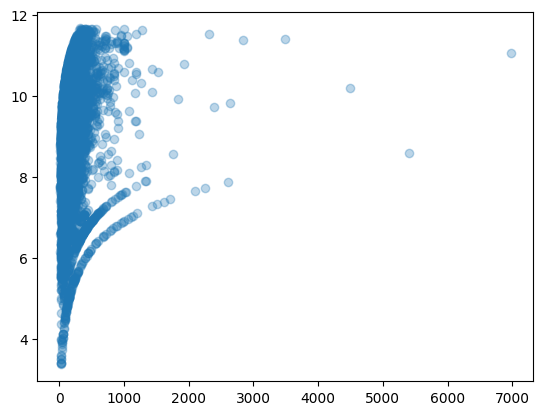

In [5]:
plt.scatter(df["price"], df["log_revenue"], alpha=0.3)
plt.show()

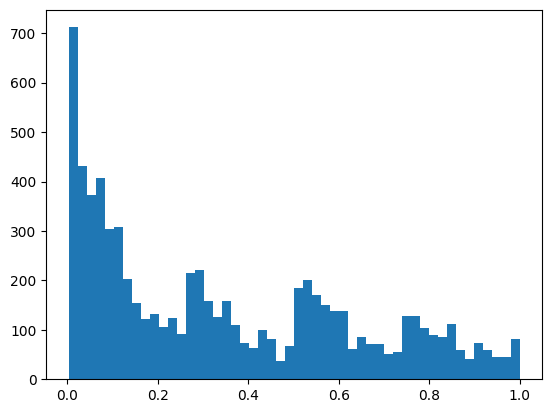

In [6]:
plt.hist(df["occupancy_proxy"], bins=50)
plt.show()

In [7]:
df.describe()

,listing_id,price,accommodates,bedrooms,bathrooms,review_scores_rating,occupancy_proxy,weekend_occupancy_proxy,summer_occupancy_proxy,winter_occupancy_proxy,total_review_count,recent_review_count,avg_review_length,estimated_annual_revenue,log_revenue
count,7.306000e+03,7306.000000,7306.000000,7300.000000,7304.000000,6042.000000,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7306.00000,7306.000000
mean,7.476653e+17,192.348754,4.437996,1.822466,1.416963,4.772069,0.343329,0.352250,0.420503,0.221267,61.899945,15.128798,202.013933,20589.98426,9.177827
std,5.641979e+17,209.686116,3.057478,1.242813,0.789487,0.398191,0.290471,0.291622,0.457016,0.346163,99.721571,19.636686,147.175435,21993.88540,1.478770
min,2.384000e+03,13.000000,1.000000,0.000000,0.000000,1.000000,0.002740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.00000,3.367296
25%,4.867521e+07,95.000000,2.000000,1.000000,1.000000,4.730000,0.079452,0.086538,0.000000,0.000000,2.000000,0.000000,142.829852,3838.50000,8.253097
50%,8.831434e+17,149.000000,4.000000,2.000000,1.000000,4.870000,0.279452,0.288462,0.054348,0.000000,21.000000,8.000000,215.825418,13116.00000,9.481664
75%,1.263134e+18,229.000000,6.000000,2.000000,2.000000,4.970000,0.567123,0.576923,1.000000,0.322222,80.000000,24.000000,262.915761,29915.00000,10.306149
max,1.514812e+18,6977.000000,16.000000,20.000000,17.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1267.000000,387.000000,5334.000000,116350.00000,11.664367


In [8]:
df.dtypes

listing_id                    int64
price                       float64
accommodates                  int64
bedrooms                    float64
bathrooms                   float64
room_type                       str
property_type                   str
review_scores_rating        float64
occupancy_proxy             float64
weekend_occupancy_proxy     float64
summer_occupancy_proxy      float64
winter_occupancy_proxy      float64
total_review_count          float64
recent_review_count         float64
avg_review_length           float64
estimated_annual_revenue    float64
log_revenue                 float64
dtype: object

## Modeling

In [9]:
#Random Forest Regressor (initial model)

y = df["log_revenue"]

exclude_cols = ["listing_id", "estimated_annual_revenue", "log_revenue"]
X = df.drop(columns=exclude_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ["room_type", "property_type"]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

model.fit(X_train, y_train)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

np.float64(0.037486214686611424)

In [10]:
import pandas as pd

feature_importances = model.named_steps["model"].feature_importances_

# Get feature names AFTER one-hot encoding
feature_names = model.named_steps["preprocess"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
}).sort_values("importance", ascending=False)

importance_df.head(10)

,feature,importance
6,num__weekend_occupancy_proxy,0.460911
5,num__occupancy_proxy,0.340812
0,num__price,0.196852
11,num__avg_review_length,0.000192
4,num__review_scores_rating,0.000159
9,num__total_review_count,0.000143
10,num__recent_review_count,0.000138
1,num__accommodates,0.000134
3,num__bathrooms,0.000131
8,num__winter_occupancy_proxy,0.000113


Data Leakage, so build a new model dropping occupancy proxy

### Base Model (Random Forest)

In [11]:
#Random Forest Regressor (baseline model)

y = df["log_revenue"]

exclude_cols = ["listing_id", "estimated_annual_revenue", "log_revenue","occupancy_proxy","weekend_occupancy_proxy","winter_occupancy_proxy","summer_occupancy_proxy"]
X = df.drop(columns=exclude_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ["room_type", "property_type"]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

model.fit(X_train, y_train)

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

np.float64(1.2692307599477954)

                                         feature  importance
0                                     num__price    0.351255
7                         num__avg_review_length    0.131626
5                        num__total_review_count    0.092712
1                              num__accommodates    0.090553
6                       num__recent_review_count    0.080205
4                      num__review_scores_rating    0.079739
2                                  num__bedrooms    0.040941
3                                 num__bathrooms    0.040639
21         cat__property_type_Entire rental unit    0.012342
22  cat__property_type_Entire serviced apartment    0.011282


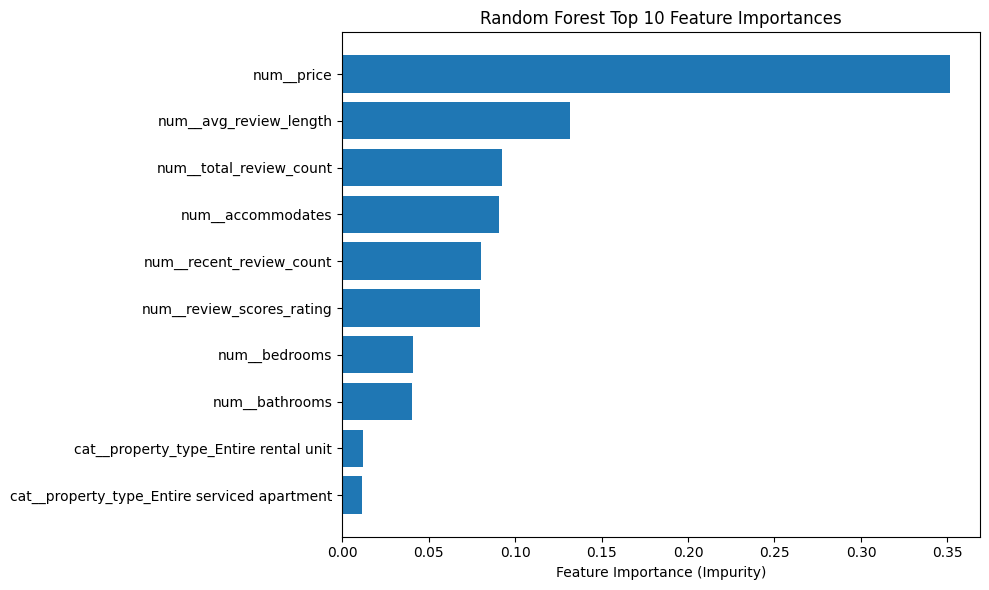

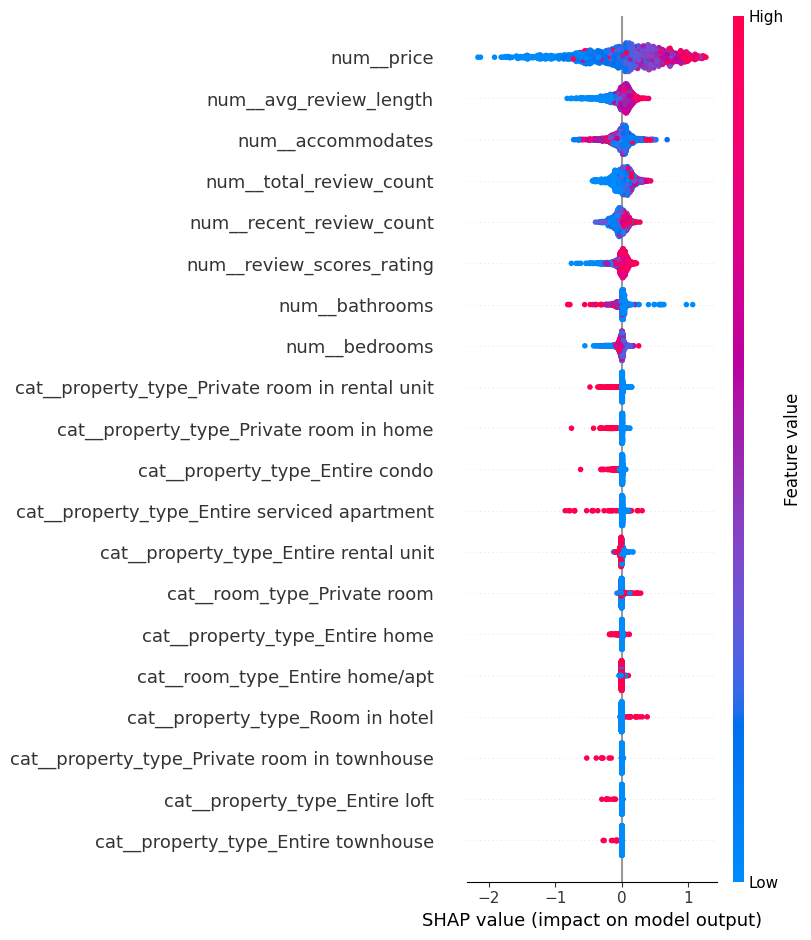

In [12]:
# ── 1. Feature Importance ──────────────────────────────────────────
feature_importances = model.named_steps["model"].feature_importances_
feature_names = model.named_steps["preprocess"].get_feature_names_out()

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances
}).sort_values("importance", ascending=False)

print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(
    importance_df["feature"].head(10)[::-1],
    importance_df["importance"].head(10)[::-1]
)
plt.xlabel("Feature Importance (Impurity)")
plt.title("Random Forest Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# ── 2. SHAP ────────────────────────────────────────────────────────
Xt = model.named_steps["preprocess"].transform(X_test)
if issparse(Xt):
    Xt_dense = Xt.toarray().astype(float)
else:
    Xt_dense = Xt.astype(float)

rf_model = model.named_steps["model"]
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(Xt_dense)

shap.summary_plot(shap_values, Xt_dense, feature_names=feature_names)

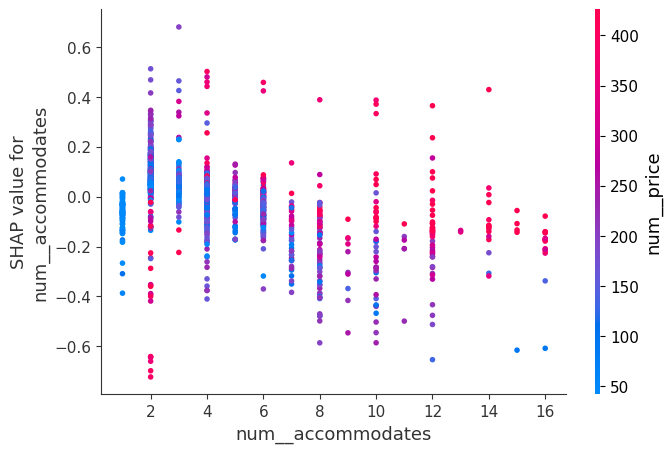

In [13]:
shap.dependence_plot("num__accommodates", shap_values, Xt_dense, feature_names)

SHAP Insights

Price dominates the model

- Higher prices increase predicted revenue, while lower prices reduce it. This aligns with basic economic intuition.

Review & engagement signals matter

- Avg review length and review counts show positive contributions, suggesting that guest engagement and listing visibility influence revenue potential.

Interesting pattern: accommodates

- Larger capacity does not consistently increase revenue impact. Smaller listings often contribute positively, while larger listings frequently push predictions downward.

Nonlinear capacity effect

- Dependence analysis indicates diminishing returns to accommodates, where increasing size alone does not guarantee higher revenue.

Overall interpretation

- Revenue is primarily price-driven, with demand and experience-related factors moderating performance.

### Advanced Model (XGBoost)

In [14]:
y = df["log_revenue"]

exclude_cols = [
    "listing_id",
    "estimated_annual_revenue",
    "log_revenue",
    "occupancy_proxy",
    "weekend_occupancy_proxy",
    "winter_occupancy_proxy",
    "summer_occupancy_proxy",
]
X = df.drop(columns=exclude_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = ["room_type", "property_type"]
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model_xgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb)
])

param_dist = {
    "model__n_estimators": [200, 300, 500],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 4, 5],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0],
}

search = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
preds = search.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'model__subsample': 0.8, 'model__reg_lambda': 1.0, 'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.7}
RMSE: 1.2593947134103225


                                              feature  importance
10                        cat__room_type_Private room    0.096861
47             cat__property_type_Shared room in home    0.064034
0                                          num__price    0.059571
22       cat__property_type_Entire serviced apartment    0.046584
45                   cat__property_type_Room in hotel    0.046008
28  cat__property_type_Private room in bed and bre...    0.041114
1                                   num__accommodates    0.031146
39     cat__property_type_Private room in rental unit    0.027773
2                                       num__bedrooms    0.027176
8                      cat__room_type_Entire home/apt    0.027027


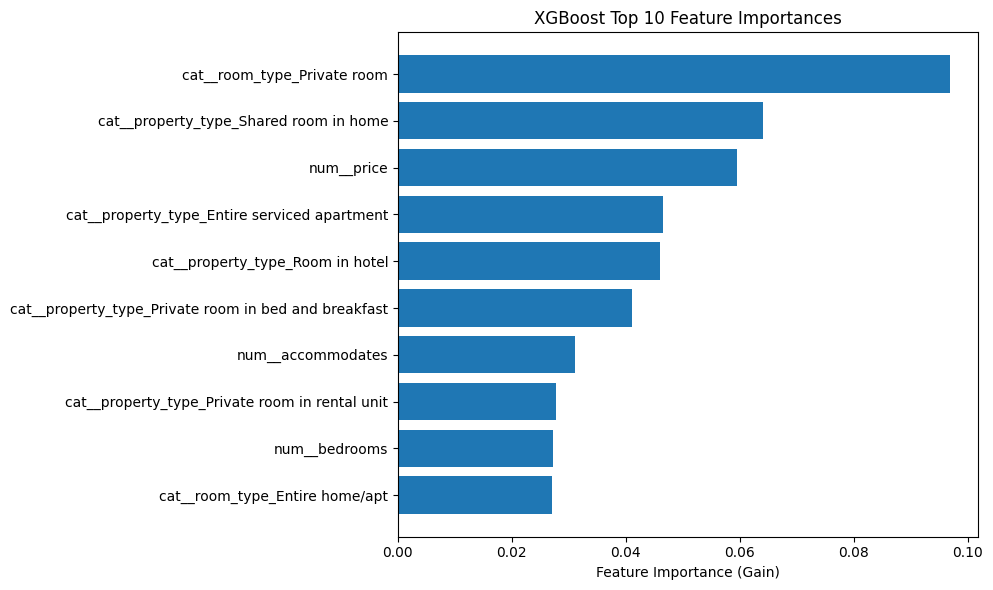

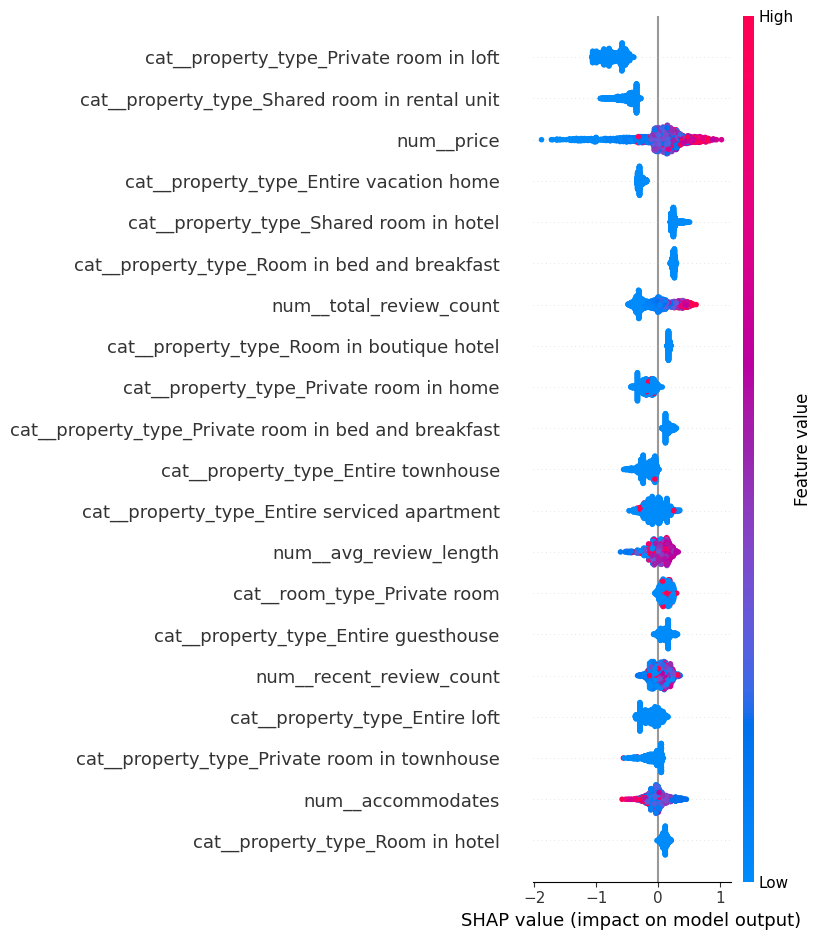

In [15]:
# ── 1. Extract best model ──────────────────────────────────────────
best_model_xgb = search.best_estimator_

X_test_transformed = best_model_xgb[:-1].transform(X_test)
if issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

feature_names = best_model_xgb.named_steps["preprocess"].get_feature_names_out()

# ── 2. Feature Importance ──────────────────────────────────────────
feature_importances_xgb = best_model_xgb.named_steps["model"].feature_importances_

importance_df_xgb = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importances_xgb
}).sort_values("importance", ascending=False)

print(importance_df_xgb.head(10))

plt.figure(figsize=(10, 6))
plt.barh(
    importance_df_xgb["feature"].head(10)[::-1],
    importance_df_xgb["importance"].head(10)[::-1]
)
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# ── 3. SHAP ────────────────────────────────────────────────────────
explainer = shap.TreeExplainer(best_model_xgb.named_steps["model"])
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

SHAP Insights (XGBoost Model)

**Listing structure dominates the model**

- Room type and property type variables play a central role in predictions. This suggests revenue differences are strongly tied to how listings are configured and positioned in the market.

**Price remains influential but not dominant**

- Higher prices generally increase predicted revenue, but the effect is less overwhelming compared to the Random Forest model. The model captures additional drivers beyond pricing alone.

**Accommodation capacity shows mixed effects**

- Accommodates contributes meaningfully, yet larger capacity does not consistently increase revenue impact. This reinforces the idea that size alone is not a guaranteed revenue driver.

**Market segmentation effects emerge**

- Specific property types (e.g., serviced apartments, hotel-style listings, shared rooms) produce distinct SHAP impacts, indicating the model learns structural differences between listing categories.

**Nonlinear feature interactions**

- Dependence patterns suggest revenue drivers operate through combined effects (structure + price + engagement), rather than isolated linear relationships.

Final conclusion for the base modeling:
The baseline models reveal two complementary perspectives: Random Forest primarily emphasizes pricing effects, while XGBoost highlights listing structure and configuration. Together, these results suggest that revenue dynamics are shaped by both economic factors (price) and market positioning factors (room/property type), providing a robust foundation for evaluating the impact of newly injected features. Further analysis required with new features added to dataset.